<img src="https://raw.githubusercontent.com/OGGM/oggm/master/files/logo.png" width="40%"  align="left">

# Getting started with flowline models: idealized experiments

In this notebook we are going to explore the basic functionalities of OGGM flowline model(s). For this purpose we are going to used simple, "idealized" glaciers, run with simple linear mass-balance profiles. 

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
# Scientific packages
import numpy as np
# Constants
from oggm.cfg import SEC_IN_YEAR
# OGGM models
from oggm.core.models.massbalance import ConstantBalanceModel
from oggm.core.models.flowline import FluxBasedModel
from oggm.core.models.flowline import VerticalWallFlowline, TrapezoidalFlowline, ParabolicFlowline
# This is to set a default parameter to a function. Just ignore it for now
from functools import partial
FlowlineModel = partial(FluxBasedModel, inplace=False)

## Basics

Set-up a simple run with a constant linear bed. We will first define the bed:

### Glacier bed

In [2]:
# This is the bed rock, linearily decreasing from 3000m altitude to 1000m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the begining, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100m (needed later)
map_dx = 100

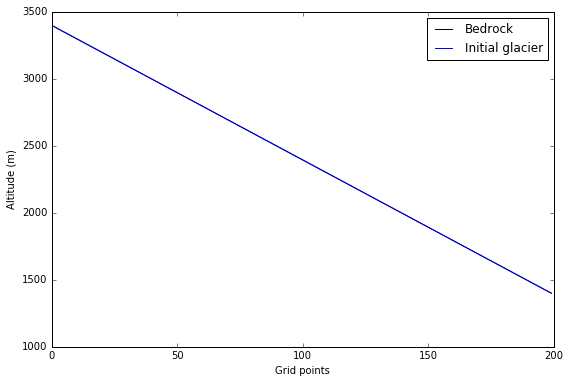

In [3]:
# plot this
plt.plot(bed_h, color='k', label='Bedrock')
plt.plot(surface_h, color='b', label='Initial glacier')
plt.xlabel('Grid points')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

Now we have to decide how wide our glacier is, and what it the *shape* of its bed. For a start, we will use a "u-shaped" bed (see the [documentation](http://oggm.readthedocs.org/en/latest/flowline.html#verticalwallflowline)), with a constant width of 300m:

In [4]:
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = VerticalWallFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

The init_flowline variable now contains all deometrical information needed by the model. It can give access to some attributes, which are quite useless for a non-existing glacier: 

In [5]:
print('Glacier length:', init_flowline.length_m)
print('Glacier area:', init_flowline.area_km2)
print('Glacier volume:', init_flowline.volume_km3)

Glacier length: 0.0
Glacier area: 0.0
Glacier volume: 0.0


### Mass balance

Then we will need a mass balance model. In our case this will be a simple linear mass-balance, defined by the equilibrium line altitude and an altitude gradient (in [mm m$^{-1}$]):

In [6]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
mb_model = ConstantBalanceModel(3000, grad=4)

The mass-balance model gives you the mass-balance for any altitude you want, in units [m s$^{-1}$]. Let us compute the *annual* mass-balance along the glacier profile:

In [7]:
annual_mb = mb_model.get_mb(surface_h) * SEC_IN_YEAR

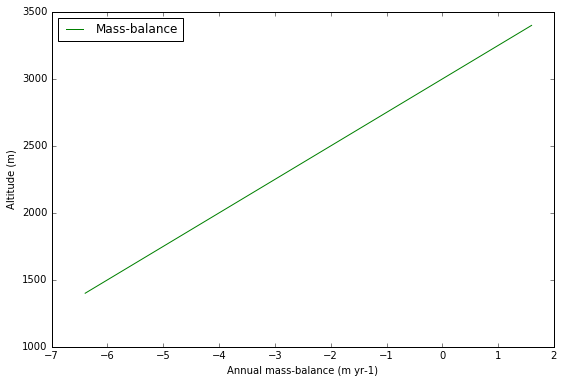

In [8]:
# Plot it
plt.plot(annual_mb, bed_h, color='g', label='Mass-balance')
plt.xlabel('Annual mass-balance (m yr-1)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

### Model run

Now that we have all the ingredients to run the model, we just have to initialize it:

In [9]:
# The model requires the initial glacier bed, a mass-balance model, and an initial time (the year y0)
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0.)

We can now run the model for 150 years and see how the output looks like:

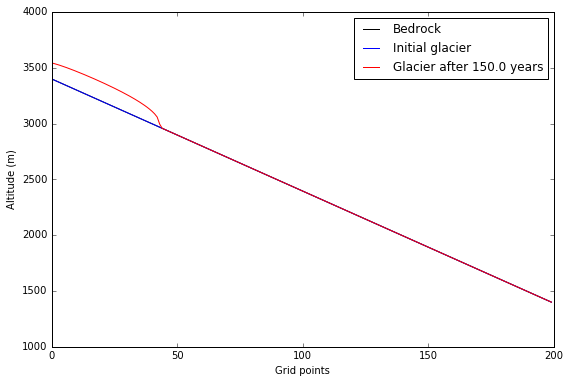

In [10]:
model.run_until(150)
# Plot the initial conditions first:
plt.plot(init_flowline.bed_h, color='k', label='Bedrock')
plt.plot(init_flowline.surface_h, color='b', label='Initial glacier')
# The get the modelled flowline (model.fls[-1]) and plot it's new surface
plt.plot(model.fls[-1].surface_h, color='r', label='Glacier after {} years'.format(model.yr))
plt.xlabel('Grid points')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

Let's print out a few infos about our glacier:

In [11]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

Year: 150.0
Glacier length (m): 4350.0
Glacier area (km2): 1.32
Glacier volume (km3): 0.201182534275


Note that the model time is now 150. Runing the model with the sane input will do nothing:

In [12]:
model.run_until(150)
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)

Year: 150.0
Glacier length (m): 4350.0


If we want to compute longer, we have to set the desired date:

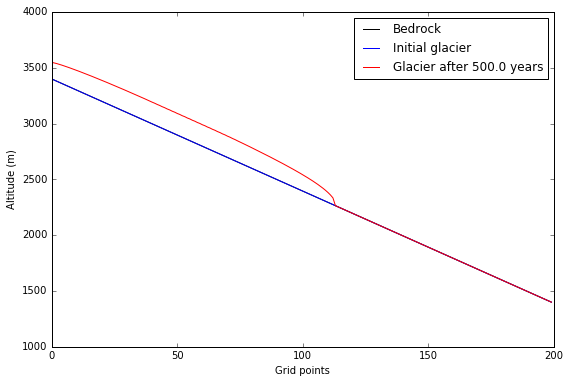

In [13]:
model.run_until(500)
# Plot the initial conditions first:
plt.plot(init_flowline.bed_h, color='k', label='Bedrock')
plt.plot(init_flowline.surface_h, color='b', label='Initial glacier')
# The get the modelled flowline (model.fls[-1]) and plot it's new surface
plt.plot(model.fls[-1].surface_h, color='r', label='Glacier after {} years'.format(model.yr))
plt.xlabel('Grid points')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

In [14]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

Year: 500.0
Glacier length (m): 11250.0
Glacier area (km2): 3.39
Glacier volume (km3): 0.596920080906


Note that in order to store some intermediate steps of the evolution of the glacier, it might be useful to make a loop:

In [15]:
# Reinitialize the model
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0.)
# Year 0 to 600 in 6 years step
yrs = np.arange(0, 600, 5)
# Array to fill with data
nsteps = len(yrs)
length = np.zeros(nsteps)
vol = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length[i] = model.length_m
    vol[i] = model.volume_km3
# I store the final results for later use
simple_glacier_h = model.fls[-1].surface_h

We can now plot the evolution of the glacier length and volume with time:

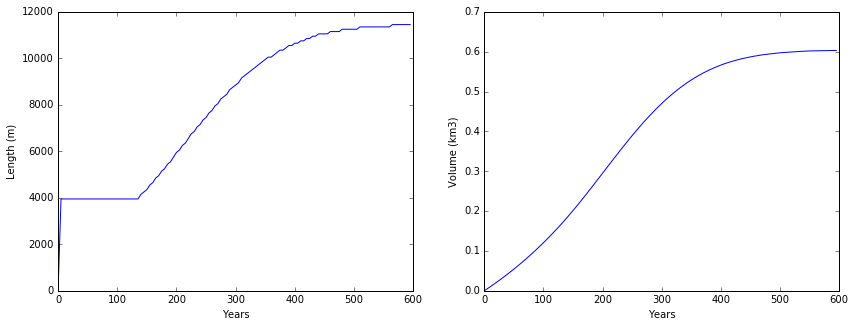

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length);
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax2.plot(yrs, vol);
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

## A first experiment 

Ok, now we have seen the basics. Will will now define a simple experiment, in which we will now make the glacier wider at the top (in the accumulation area). This is a common situation for valley glaciers.

In [17]:
# We define the widths as before:
widths = np.zeros(nx) + 3.
# But we now make our glacier 600 me wide fir the first grid points:
widths[0:15] = 6
# Define our new bed
wider_flowline = VerticalWallFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

We will now run our model with the new inital conditions, and store the output in a new variable for comparison:

In [18]:
# Reinitialize the model with the new input
model = FlowlineModel(wider_flowline, mb_model=mb_model, y0=0.)
# Array to fill with data
nsteps = len(yrs)
length_w = np.zeros(nsteps)
vol_w = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length_w[i] = model.length_m
    vol_w[i] = model.volume_km3
# I store the final results for later use
wider_glacier_h = model.fls[-1].surface_h

Compare the results:

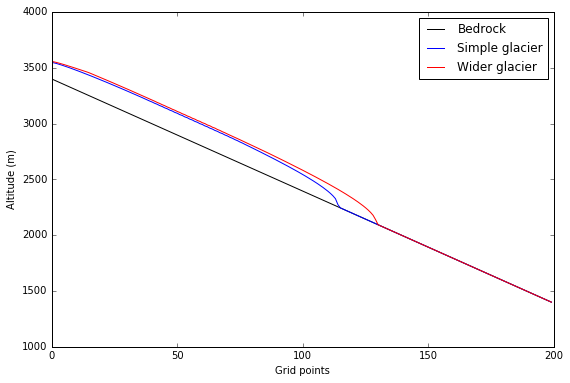

In [19]:
# Plot the initial conditions first:
plt.plot(init_flowline.bed_h, color='k', label='Bedrock')
# Then the final result
plt.plot(simple_glacier_h, color='b', label='Simple glacier')
plt.plot(wider_glacier_h, color='r', label='Wider glacier')
plt.xlabel('Grid points')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

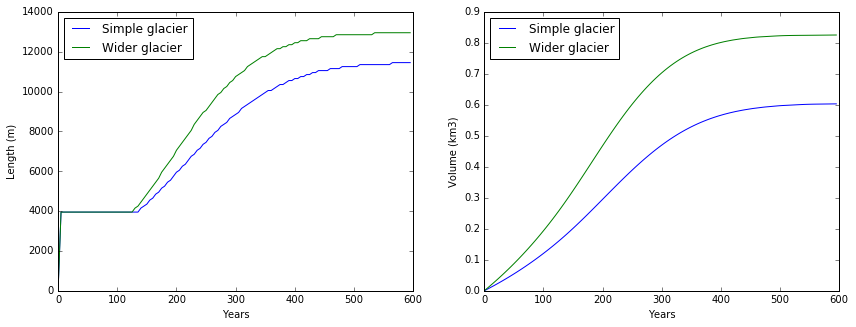

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length, label='Simple glacier');
ax1.plot(yrs, length_w, label='Wider glacier');
ax1.legend(loc='best')
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax2.plot(yrs, vol, label='Simple glacier');
ax2.plot(yrs, vol_w, label='Wider glacier');
ax2.legend(loc='best')
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

## More experiments

These simple models of glacier evolution are extremely useful tools to learn about the behavior of glaciers. Here is a non-exhaustive list of questions that one could address with this simple model:
- study the response time and equilibrium states of glaciers with different slopes
- study glaciers with variying bed types (deepenings, etc)
- start with glaciers in various equilibrium states. Aply step-wise changes in the mass-balance and see which glaciers respond faster
- ...